In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 利用BP神经网络进行函数拟合
https://blog.csdn.net/qq_43530128/article/details/103939508
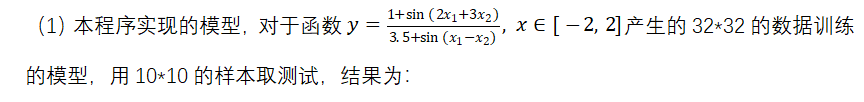\
可以拟合任意曲线

In [18]:
#产生数据，并将产生的数据方阵降维，方便计算处理
def init(inpit_n_row):
    X1 = np.linspace(-2, 2, int(inpit_n_row**0.5))
    X2 = np.linspace(-2, 2, int(inpit_n_row**0.5))
    X1, X2 = np.meshgrid(X1, X2)
    X1 = X1.reshape(-1)
    X2 = X2.reshape(-1)
    x, y = [], []
    for i in range(inpit_n_row):
        # 增加高斯白噪声
        #a = np.random.random() - 0.5
        #a /= 5
        x.append([X1[i], X2[i]])
        Y = (1 + np.sin(2 * X1[i] + 3 * X2[i])) / (3.5 + np.sin(X1[i] - X2[i])) # + a
        y.append(Y)
    # 增加野值
    '''b = np.random.randint(0, 9) - 0.5
    b /= 9
    post = np.random.randint(0, inpit_n_row - 1)
    y[post] += b'''
    x = np.array(x)
    y = np.array([y]).T
    return x,y

# 激活函数
def relu(x):
    return np.maximum(0,x)

# 激活函数RELU的导数
def d_relu(x):
    x[x<0] = 0
    return x

# 归一化数据
def normalize(data):
    data_min, data_max = data.min(), data.max()
    data = (data - data_min) / (data_max - data_min)
    return data

# 反归一化数据
def d_normalize(norm_data, data):
    data_min, data_max = data.min(), data.max()
    return norm_data * (data_max - data_min) + data_min

# 计算损失函数：平方损失函数
def quadratic_cost(y_, y):
    inpit_n_row = len(y)
    return np.sum(1 / inpit_n_row * np.square(y_ - y))

# 评价函数RSSE
def rsse(y_predict, y):
    y_ = np.mean(y)
    return np.sum(np.square(y_predict - y))/np.sum(np.square(y-y_))

# 前向传播算法
def prediction(l0, W, B):
    Layers = [l0]
    for i in range(len(W)):
        Layers.append(relu(x=Layers[-1].dot(W[i]) + B[i]))
    return Layers

# 反向传播算法：根据损失函数优化各个隐藏层的权重
def optimizer(Layers, W, B, y, learn_rate):
    l_error_arr = [(y - Layers[-1]) * d_relu(x=Layers[-1])]
    for i in range(len(W) - 1, 0, -1):
        l_error_arr.append(l_error_arr[-1].dot(W[i].T) * d_relu(x=Layers[i]))
    j = 0  # l_delta_arr = [err3, err2, err1]
    for i in range(len(W) - 1, -1, -1):
        W[i] += learn_rate * Layers[i].T.dot(l_error_arr[j])  # W3 += h2 * err3
        B[i] += learn_rate * l_error_arr[j]  # B3 += err3
        j += 1

# 训练BP神经网络
def train(X, y, W, B, method, learn_rate):
    #norm_X, norm_y = normalize(data=X), normalize(data=y)  # 归一化处理
    norm_X = X
    norm_y = y  # 由于测试模型无负值，无需归一化处理，可极大提高效率

    #加了噪声之后，需降低精度要求，降低至0.1即可
    end_loss = 0.001
    step_arr, loss_arr, rsse_arr = [], [], []
    step = 1
    if method == '训练集':
        error = '偏差'
    else:
        error = '方差'
    while True:
        Layers = prediction(l0=norm_X, W=W, B=B)
        rsse_now = rsse(y_predict=Layers[-1], y=norm_y)
        learn_rate_decay = learn_rate # * 1.0 / (1 + step * 0.001)
        optimizer(Layers=Layers, W=W, B=B, y=y, learn_rate=learn_rate_decay)
        cur_loss = quadratic_cost(y_=Layers[-1], y=norm_y)
        if step % 1000 == 0:
            step_arr.append(step)
            loss_arr.append(cur_loss)
            rsse_arr.append(rsse_now)
            print('经过{}次迭代，{}当前{}为{}，RSSE为{}'.format(step, method, error, cur_loss, rsse_now))
        if rsse_now < end_loss:
            # prediction_ys = d_normalize(norm_data=Layers[-1], data=y)  # 反归一化结果
            print('经过{}次迭代，{}最终{}为{}，RSSE为{}'.format(step, method, error, cur_loss, rsse_now))
            return 0, Layers[-1]
        if len(rsse_arr) >= 2 and rsse_arr[-2] - rsse_arr[-1] < 1e-5 or step > 50000:
            print('此初始权重可能导致算法陷入局部极值，故随机重启，重新迭代')
            return -1, []
        step += 1

# 拟合曲面可视化
def visualize(y, inpit_n_row, input_n_col, hidden_n_1):
    z = []
    for i in y:
        for j in i:
            z.append(j)
    z = np.array(z).reshape(int(inpit_n_row**0.5), int(inpit_n_row**0.5))
    # 代入训练好的模型测试
    flag = -1
    while flag == -1:
        np.random.seed(random_restart())
        # 产生测试集
        test_n_row = 100
        x_test, y_test = init(test_n_row)
        W1 = np.random.randn(input_n_col, hidden_n_1) / np.sqrt(test_n_row)
        b1 = np.zeros((test_n_row, hidden_n_1))
        # 输出层权重矩阵
        W2 = np.random.randn(hidden_n_1, 1) / np.sqrt(test_n_row)
        b2 = np.zeros((test_n_row, 1))
        w, b = [W1, W2], [b1, b2]
        flag, y_test = train(x_test, y_test, w, b, '测试集', learn_rate=0.15)
    z_test = []
    for i in y_test:
        for j in i:
            z_test.append(j)
    z_test = np.array(z_test).reshape(int(test_n_row ** 0.5), int(test_n_row ** 0.5))
    # 拟合曲面可视化
    X1 = np.linspace(-2, 2, int(inpit_n_row**0.5))
    X2 = np.linspace(-2, 2, int(inpit_n_row**0.5))
    X1, X2 = np.meshgrid(X1, X2)
    Z = (1 + np.sin(2 * X1 + 3 * X2)) / (3.5 + np.sin(X1 - X2))
    fig = plt.figure(figsize=(20, 16))  
    ax = fig.add_subplot(311, projection='3d')  
    # 画出真实函数  
    ax.set_xlabel('X1')  
    ax.set_ylabel('X2')  
    ax.set_title('y')  
    ax.plot_surface(X1, X2, Z, color='red')  
    # 画出预测函数
    # ax = Axes3D(fig)
    ax2 = fig.add_subplot(312, projection='3d')  
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_title('y_predict')
    ax2.plot_surface(X1, X2, z, color='blue')
    # 画出测试结果
    X1 = np.linspace(-2, 2, int(test_n_row ** 0.5))
    X2 = np.linspace(-2, 2, int(test_n_row ** 0.5))
    X1, X2 = np.meshgrid(X1, X2)
    ax3 = fig.add_subplot(313, projection='3d')  
    # ax = Axes3D(fig)
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')
    ax3.set_title('y_test')
    ax3.plot_surface(X1, X2, z_test, color='yellow')
    plt.tight_layout()
    plt.show()

# 为了解决陷入局部极小值，随机重启
def random_restart():
    return np.random.randint(0, 2378)

In [3]:
inpit_n_row = 1024
# 输入维度
input_n_col = 2
# 神经元个数
hidden_n_1 = 20
flag = -1
while flag == -1:
    np.random.seed(random_restart())
    x, y = init(inpit_n_row)
    # 第一个隐藏层权重矩阵
    W1 = np.random.randn(input_n_col, hidden_n_1) / np.sqrt(inpit_n_row)
    b1 = np.zeros((inpit_n_row, hidden_n_1))
    # 输出层权重矩阵
    W2 = np.random.randn(hidden_n_1, 1) / np.sqrt(inpit_n_row)
    b2 = np.zeros((inpit_n_row, 1))
    W, B = [W1, W2], [b1, b2]
    flag, y = train(x, y, W, B, '训练集', learn_rate=0.001)  # 开始训练BP神经网络

经过1000次迭代，训练集当前偏差为0.12640326096558785，RSSE为2.5883449838070494
经过2000次迭代，训练集当前偏差为0.04969825208401306，RSSE为1.0176653711540993
经过3000次迭代，训练集当前偏差为0.029267544598352895，RSSE为0.599308132328321
经过4000次迭代，训练集当前偏差为0.01372625633814388，RSSE为0.28107096658650826
经过5000次迭代，训练集当前偏差为0.00776043248769624，RSSE为0.15890948024806292
经过6000次迭代，训练集当前偏差为0.004625975539464742，RSSE为0.09472556713586198
经过7000次迭代，训练集当前偏差为0.0029063180767768364，RSSE为0.059512339775957386
经过8000次迭代，训练集当前偏差为0.0019504928510654458，RSSE为0.039940016961913495
经过9000次迭代，训练集当前偏差为0.0014015031470526382，RSSE为0.028698418163840438
经过10000次迭代，训练集当前偏差为0.0010689903262267723，RSSE为0.02188959151441983
经过11000次迭代，训练集当前偏差为0.0007951864166773416，RSSE为0.01628294046431785
经过12000次迭代，训练集当前偏差为0.000591510678632838，RSSE为0.012112295887084908
经过13000次迭代，训练集当前偏差为0.0004714060735228004，RSSE为0.009652927752165313
经过14000次迭代，训练集当前偏差为0.0003999350924862928，RSSE为0.008189424723521334
经过15000次迭代，训练集当前偏差为0.000339699312219692，RSSE为0.006955983604140678
经过16000次迭代，训练集当前偏差为0.0002830

In [32]:
W[0].shape[1]

20

经过228次迭代，测试集最终方差为4.850493430161725e-05，RSSE为0.0009933904540363218


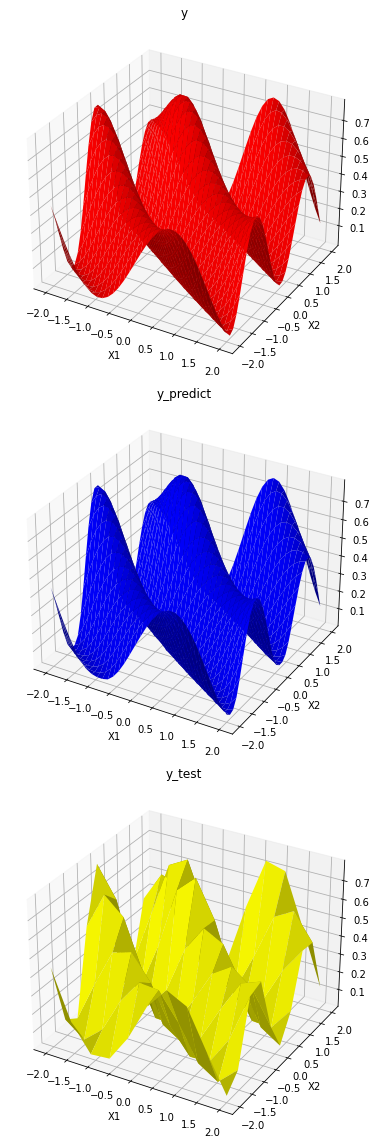

In [19]:
visualize(y, inpit_n_row, input_n_col, hidden_n_1)

## 少量遍历 神经网络 优化
神经网络的特点：处理高维和复杂问题：在高维空间中，单纯依赖已有数据寻找最优值可能会遇到“维度灾难”。神经网络擅长处理高维数据，可以通过学习特征的组合来找到更优解。

1. 训练集：训练集是神经网络用于学习的样本数据集。训练集的大小决定了网络的复杂度和拟合能力。
2. 验证集：验证集用于评估模型的性能。验证集的大小一般为训练集的10%~20%。
3. 测试集：测试集用于最终评估模型的性能。测试集的大小一般为训练集的10%~20%。
   
通过神经网络寻找规律，找到最优值。

关于`少量遍历`：老师的意思是训练集的数据比较少？训练集数据少容易导致过拟合问题\
可以利用领域知识来设计特征或约束模型的结构，可以帮助模型更好地理解数据，即使数据量较少

32.0